# Name: Saran Adhikari

# University ID: 2329794


# Image Classification with Convolutional Neural Network

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import random
from PIL import Image
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix

In [ ]:
# setting random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = "/content/drive/MyDrive/AI&ML/Fruit Classification/Train"
test_dir = "/content/drive/MyDrive/AI&ML/Fruit Classification/Test"

# **DATA UNDERSTANDING, ANALYSIS, VISUALIZATION AND CLEANING**

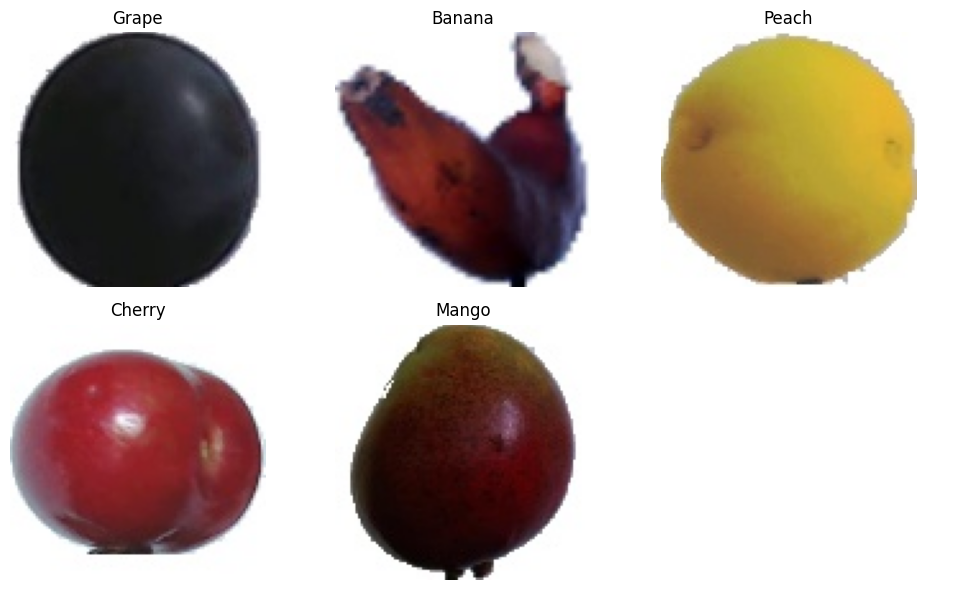

In [ ]:
class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

selected_images = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    images = os.listdir(class_path)

    if images:
        selected_image = random.choice(images)
        selected_images.append((class_name, os.path.join(class_path, selected_image)))

num_classes = len(selected_images)
cols = (num_classes + 1) // 2

fig, axes = plt.subplots(2, cols, figsize=(10, 6))
axes = axes.flatten()

for i, (class_name, image_path) in enumerate(selected_images):
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(class_name)
    axes[i].axis("off")

for i in range(len(selected_images), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
class_image_counts = {}

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    class_image_counts[class_name] = len(images)

for class_name, count in class_image_counts.items():
    print(f"{class_name}: {count} images")


Grape: 1475 images
Banana: 1429 images
Peach: 1229 images
Cherry: 1229 images
Mango: 915 images


In [ ]:
test_class_names = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]

test_image_counts = {}

for class_name in test_class_names:
    class_path = os.path.join(test_dir, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    test_image_counts[class_name] = len(images)

for class_name, count in test_image_counts.items():
    print(f"{class_name} class : {count} images")

Banana class : 1 images
Grape class : 1 images
Peach class : 1 images
Mango class : 1 images
Cherry class : 1 images


The fruit classification dataset contains two folders i.e. Test and Train. The train folder contains images from 5 different fruit classes: Banana, Mango, Cherry, Grape and Peach. The test folder contains an unknown class with 5 images which will be used during testing of classification of the images.

**Grape class** contains 1475 images

**Banana class** contains 1429 images

**Peach class** contains 1229 images

**Cherry class** contains 1232 images

**Mango class** contains 915 images

**Checking Corrupted Image**

In [ ]:
corrupted_images = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")


if not corrupted_images:
    print("No corrupted images found.")
else:
    print(f"Total corrupted images removed: {len(corrupted_images)}")

Removed corrupted image: /content/drive/MyDrive/AI&ML/Fruit Classification/Train/Grape/r_354_100.jpg
Removed corrupted image: /content/drive/MyDrive/AI&ML/Fruit Classification/Train/Grape/r_533_100.jpg
Removed corrupted image: /content/drive/MyDrive/AI&ML/Fruit Classification/Train/Grape/r_608_100.jpg
Removed corrupted image: /content/drive/MyDrive/AI&ML/Fruit Classification/Train/Grape/r_147_100(1).jpg
Removed corrupted image: /content/drive/MyDrive/AI&ML/Fruit Classification/Train/Grape/r_209_100.jpg
Removed corrupted image: /content/drive/MyDrive/AI&ML/Fruit Classification/Train/Grape/r_180_100(1).jpg
Removed corrupted image: /content/drive/MyDrive/AI&ML/Fruit Classification/Train/Grape/245_100(1).jpg
Removed corrupted image: /content/drive/MyDrive/AI&ML/Fruit Classification/Train/Banana/136_100.jpg
Removed corrupted image: /content/drive/MyDrive/AI&ML/Fruit Classification/Train/Banana/r_95_100.jpg
Removed corrupted image: /content/drive/MyDrive/AI&ML/Fruit Classification/Train/Bana

**Data Preprocessing and Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=1,
    class_mode= 'categorical',
    shuffle=False
)

Found 4996 images belonging to 5 classes.
Found 1246 images belonging to 5 classes.
Found 5 images belonging to 5 classes.


Resized the images to 100 x 100 px. Normalized px values to  [0,1]. Applied different forms of augmentation techniques such as rotation, height/width shift, horizontal flip and zoom.

# **Design, Train and Evaluate Baseline Model**

In [ ]:
baseline_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])

baseline_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

baseline_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,812,229 (25.99 MB)

 Trainable params: 6,812,229 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

**Model Training**

In [ ]:
history_baseline = baseline_model.fit(
    train_generator,
    epochs=15,
    batch_size = 16,
    validation_data=validation_generator,
    verbose=1,
    callbacks = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 48s 263ms/step - accuracy: 0.6709 - loss: 0.8118 - val_accuracy: 0.9438 - val_loss: 0.1684
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 71s 218ms/step - accuracy: 0.9454 - loss: 0.1516 - val_accuracy: 0.9551 - val_loss: 0.1145
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step - accuracy: 0.9855 - loss: 0.0473 - val_accuracy: 0.9639 - val_loss: 0.0856
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 223ms/step - accuracy: 0.9867 - loss: 0.0413 - val_accuracy: 0.9904 - val_loss: 0.0404
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 243ms/step - accuracy: 0.9945 - loss: 0.0202 - val_accuracy: 0.9952 - val_loss: 0.0189
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 220ms/step - accuracy: 0.9811 - loss: 0.0569 - val_accuracy: 0.9864 - val_loss: 0.0404
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 222ms/step - accuracy: 0.9883 - loss: 0.0415 - val_accuracy: 0.9839 - val_loss: 0.0501
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - accuracy: 0.9916 - loss: 0

**Training vs Validation Loss**

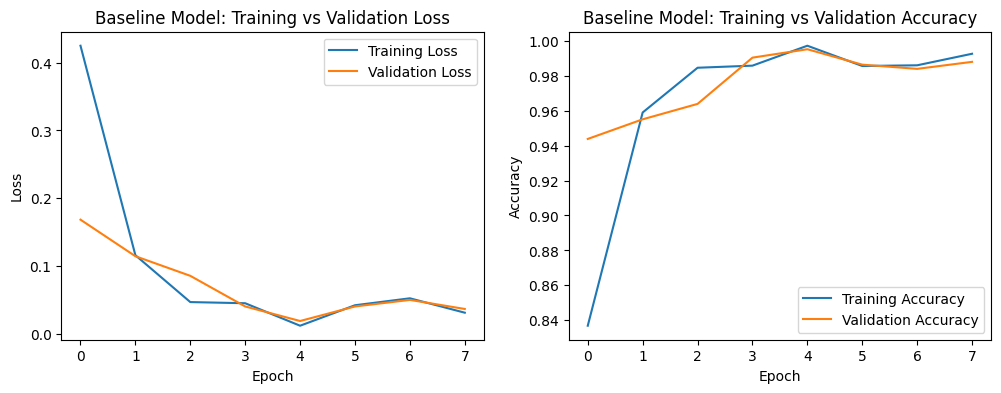

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['accuracy'], label='Training Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Model Evaluation, Prediction and Metrics**

In [ ]:
#classification report for baseline model
test_generator.reset()
baseline_preds = baseline_model.predict(test_generator, verbose=1)
baseline_pred_classes = np.argmax(baseline_preds, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report - Baseline Model:")
print(classification_report(true_classes, baseline_pred_classes, target_names=class_labels))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step
Classification Report - Baseline Model:
              precision    recall  f1-score   support

      Banana       1.00      1.00      1.00         1
      Cherry       1.00      1.00      1.00         1
       Grape       0.00      0.00      0.00         1
       Mango       0.00      0.00      0.00         1
       Peach       1.00      1.00      1.00         1

    accuracy                           0.60         5
   macro avg       0.60      0.60      0.60         5
weighted avg       0.60      0.60      0.60         5



In [ ]:
predictions = baseline_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
class_names = list(train_generator.class_indices.keys())
predicted_labels = [class_names[i] for i in predicted_classes]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


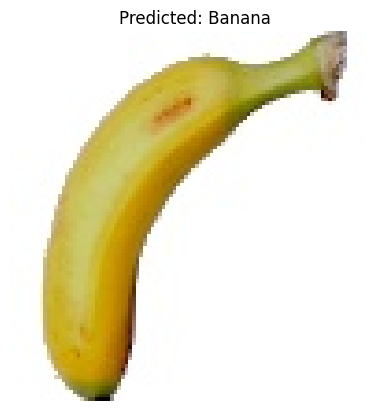

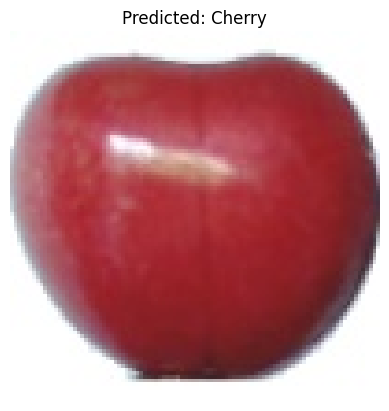

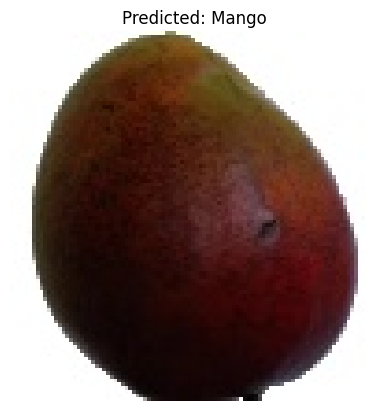

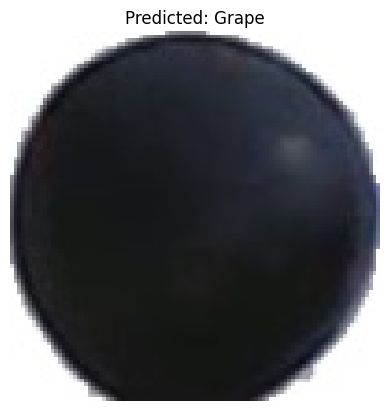

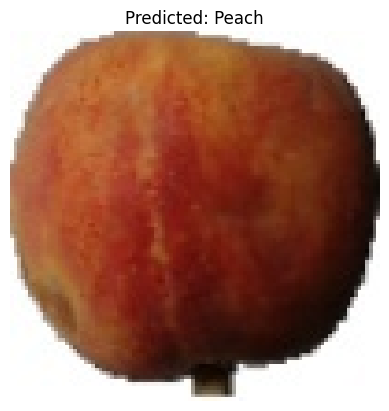

In [ ]:
# Set path to test data directory
test_data_dir = test_generator.directory

# Loop through filenames and predicted labels
for fn, label in zip(test_generator.filenames, predicted_labels):
    img_path = os.path.join(test_data_dir, fn)
    img = mpimg.imread(img_path)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {label}")
    plt.show()


# **Design, Train and Evaluate Deepr Architecture with Regularization**

In [ ]:
deeper_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
deeper_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

deeper_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,652,869 (10.12 MB)

 Trainable params: 2,651,909 (10.12 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
history_deeper = deeper_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    verbose=1,
    callbacks = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 48s 260ms/step - accuracy: 0.6207 - loss: 1.7271 - val_accuracy: 0.4398 - val_loss: 2.8100
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 72s 224ms/step - accuracy: 0.8924 - loss: 0.4232 - val_accuracy: 0.4767 - val_loss: 2.8593
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 224ms/step - accuracy: 0.9235 - loss: 0.3280 - val_accuracy: 0.6348 - val_loss: 2.0006
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 253ms/step - accuracy: 0.9274 - loss: 0.2893 - val_accuracy: 0.9165 - val_loss: 0.2558
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 275ms/step - accuracy: 0.9621 - loss: 0.1316 - val_accuracy: 0.7986 - val_loss: 0.6939
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 278ms/step - accuracy: 0.9489 - loss: 0.1943 - val_accuracy: 0.8194 - val_loss: 0.4813
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step - accuracy: 0.9652 - loss: 0.1425 - val_accuracy: 0.9743 - val_loss: 0.0884
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 241ms/step - accuracy: 0.9823 - loss: 0

**Training vs Validation Loss**

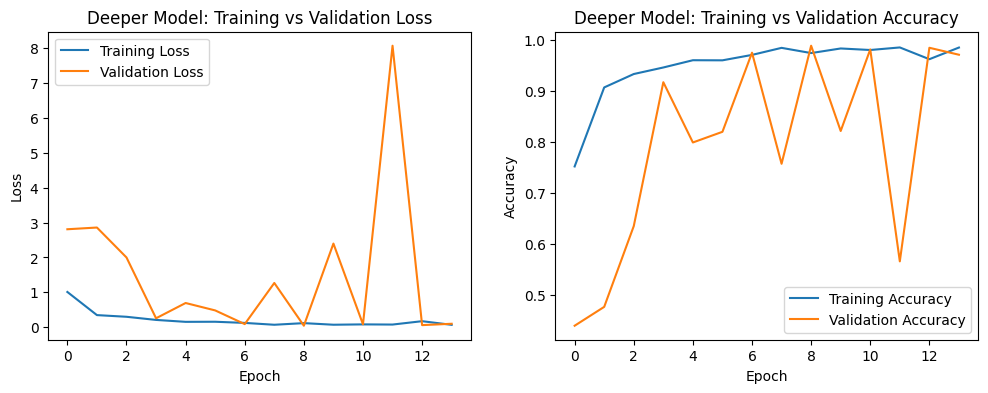

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_deeper.history['loss'], label='Training Loss')
plt.plot(history_deeper.history['val_loss'], label='Validation Loss')
plt.title('Deeper Model: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_deeper.history['accuracy'], label='Training Accuracy')
plt.plot(history_deeper.history['val_accuracy'], label='Validation Accuracy')
plt.title('Deeper Model: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Model Evaluation, Predictions and Metrics**

In [ ]:
# Classification Report for Deeper Model
test_generator.reset()
deeper_preds = deeper_model.predict(test_generator, verbose=1)
deeper_pred_classes = np.argmax(deeper_preds, axis=1)
true_classes_deep = test_generator.classes
class_labels_deep = list(test_generator.class_indices.keys())

print("Classification Report - Deeper CNN Model:")
print(classification_report(true_classes_deep, deeper_pred_classes, target_names=class_labels_deep))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Classification Report - Deeper CNN Model:
              precision    recall  f1-score   support

      Banana       1.00      1.00      1.00         1
      Cherry       1.00      1.00      1.00         1
       Grape       0.00      0.00      0.00         1
       Mango       0.00      0.00      0.00         1
       Peach       1.00      1.00      1.00         1

    accuracy                           0.60         5
   macro avg       0.60      0.60      0.60         5
weighted avg       0.60      0.60      0.60         5



In [ ]:
d_predictions = deeper_model.predict(test_generator, verbose=1)
d_predicted_classes = np.argmax(d_predictions, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
class_names = list(train_generator.class_indices.keys())
d_predicted_labels = [class_names[i] for i in d_predicted_classes]

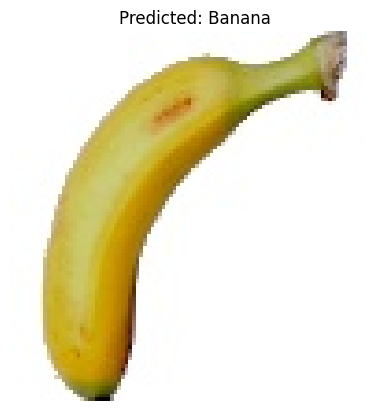

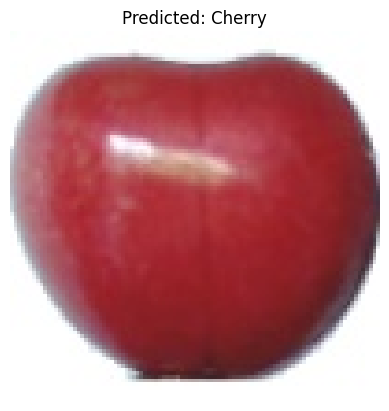

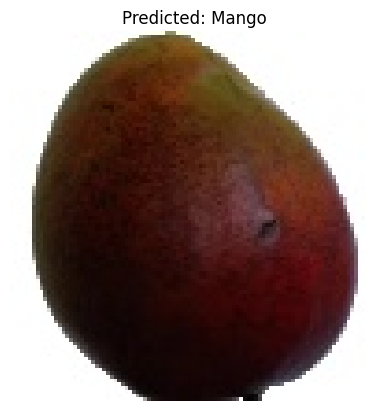

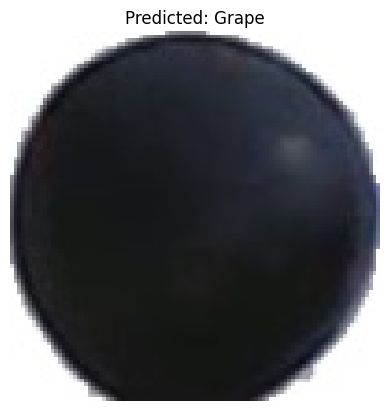

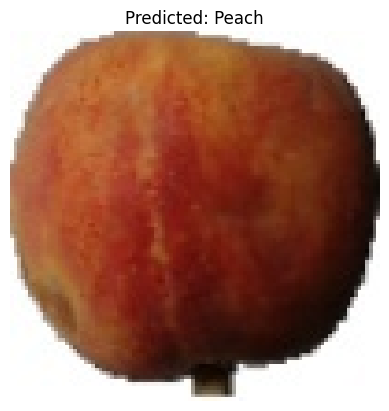

In [ ]:
# Set path to test data directory
test_data_dir = test_generator.directory

# Loop through filenames and predicted labels
for fn, label in zip(test_generator.filenames, d_predicted_labels):
    img_path = os.path.join(test_data_dir, fn)
    img = mpimg.imread(img_path)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {label}")
    plt.show()


# **Experimentation and Comparative Analysis**

In [ ]:
deeper_model_sgd = models.clone_model(deeper_model)
deeper_model_sgd.compile(optimizer='sgd',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [ ]:
history_sgd = deeper_model_sgd.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    verbose=1,
    callbacks = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 242ms/step - accuracy: 0.5223 - loss: 1.6531 - val_accuracy: 0.4703 - val_loss: 1.1289
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 224ms/step - accuracy: 0.8389 - loss: 0.4680 - val_accuracy: 0.5666 - val_loss: 1.2900
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 239ms/step - accuracy: 0.8927 - loss: 0.3199 - val_accuracy: 0.3965 - val_loss: 3.2588
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.9239 - loss: 0.2397 - val_accuracy: 0.9671 - val_loss: 0.1299
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 222ms/step - accuracy: 0.9545 - loss: 0.1434 - val_accuracy: 0.9438 - val_loss: 0.2082
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.9639 - loss: 0.1216 - val_accuracy: 0.8933 - val_loss: 0.3410
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 224ms/step - accuracy: 0.9678 - loss: 0.1135 - val_accuracy: 0.9743 - val_loss: 0.0956
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 230ms/step - accuracy: 0.9770 - loss: 0

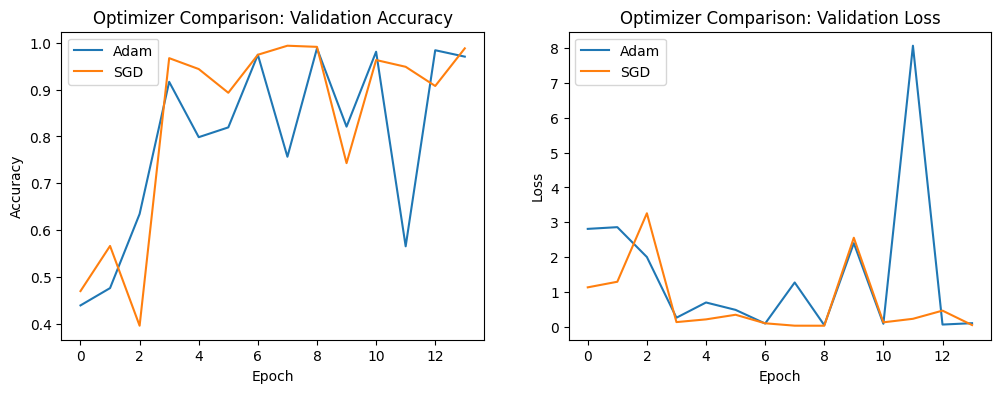

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_deeper.history['val_accuracy'], label='Adam')
plt.plot(history_sgd.history['val_accuracy'], label='SGD')
plt.title('Optimizer Comparison: Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_deeper.history['val_loss'], label='Adam')
plt.plot(history_sgd.history['val_loss'], label='SGD')
plt.title('Optimizer Comparison: Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
sgd_predictions = deeper_model.predict(test_generator, verbose=1)
sgd_predicted_classes = np.argmax(sgd_predictions, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
true_classes_sgd = test_generator.classes
class_labels_sgd= list(test_generator.class_indices.keys())

print("Classification Report - SGD Optimizer:")
print(classification_report(true_classes, sgd_predicted_classes, target_names=class_labels_sgd))


Classification Report - VGG Model (Training Data):
              precision    recall  f1-score   support

      Banana       1.00      1.00      1.00         1
      Cherry       1.00      1.00      1.00         1
       Grape       0.00      0.00      0.00         1
       Mango       0.00      0.00      0.00         1
       Peach       1.00      1.00      1.00         1

    accuracy                           0.60         5
   macro avg       0.60      0.60      0.60         5
weighted avg       0.60      0.60      0.60         5



In [ ]:
class_names = list(train_generator.class_indices.keys())
sgd_predicted_labels = [class_names[i] for i in sgd_predicted_classes]

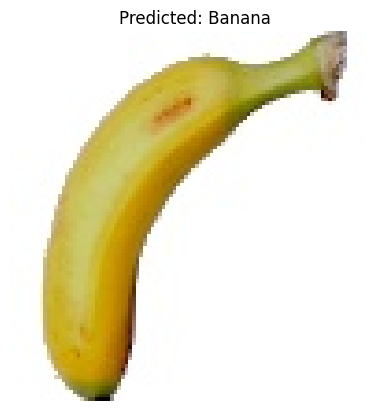

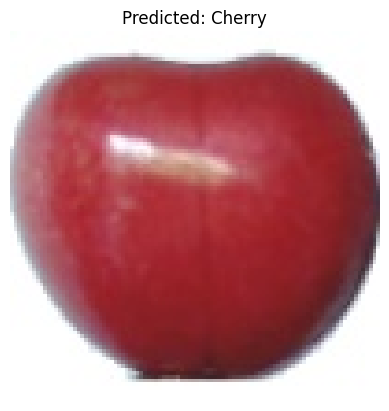

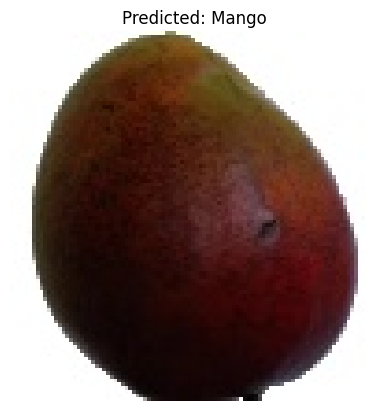

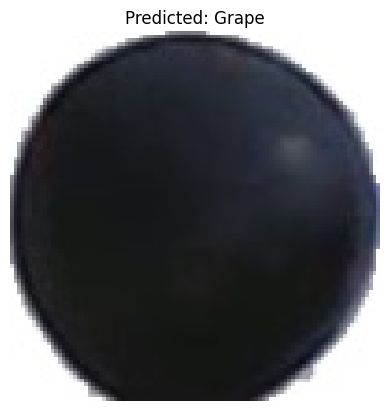

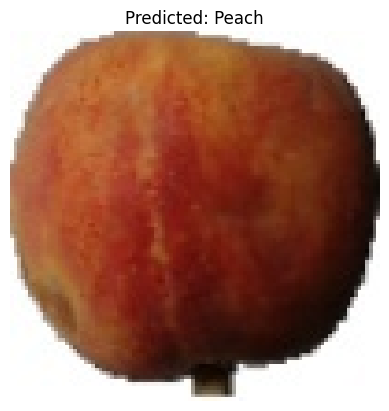

In [ ]:
# Set path to test data directory
test_data_dir = test_generator.directory

# Loop through filenames and predicted labels
for fn, label in zip(test_generator.filenames, sgd_predicted_labels):
    img_path = os.path.join(test_data_dir, fn)
    img = mpimg.imread(img_path)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {label}")
    plt.show()


# **Fine-Tuning a Pre-Trained Model (Transfer Learning)**

**Loading VGG16**

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

**Adding Custom Layers**

In [ ]:
vgg_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

In [ ]:
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

vgg_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,692,869 (105.64 MB)

 Trainable params: 12,978,181 (49.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Data Generations for VGG (224 x 224 input)**

In [ ]:
train_datagen_vgg = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

test_datagen_vgg = ImageDataGenerator(rescale=1./255)

train_generator_vgg = train_datagen_vgg.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator_vgg = train_datagen_vgg.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator_vgg = test_datagen_vgg.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 4996 images belonging to 5 classes.
Found 1246 images belonging to 5 classes.
Found 5 images belonging to 5 classes.


**Model Training**

In [ ]:
history_vgg = vgg_model.fit(
    train_generator_vgg,
    epochs=20,
    validation_data=validation_generator_vgg,
    verbose=1,
    callbacks = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 145s 885ms/step - accuracy: 0.4736 - loss: 1.3182 - val_accuracy: 0.8331 - val_loss: 0.5683
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 109s 693ms/step - accuracy: 0.8138 - loss: 0.5090 - val_accuracy: 0.8957 - val_loss: 0.2955
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 100s 640ms/step - accuracy: 0.9021 - loss: 0.2837 - val_accuracy: 0.9230 - val_loss: 0.2142
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 101s 642ms/step - accuracy: 0.9351 - loss: 0.1976 - val_accuracy: 0.9551 - val_loss: 0.1389
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 100s 634ms/step - accuracy: 0.9601 - loss: 0.1261 - val_accuracy: 0.9687 - val_loss: 0.0989
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 100s 639ms/step - accuracy: 0.9632 - loss: 0.1126 - val_accuracy: 0.9719 - val_loss: 0.0822
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 99s 627ms/step - accuracy: 0.9667 - loss: 0.0962 - val_accuracy: 0.9607 - val_loss: 0.0961
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 99s 632ms/step - accuracy: 0.9814 - l

# **Training vs Validation Loss**

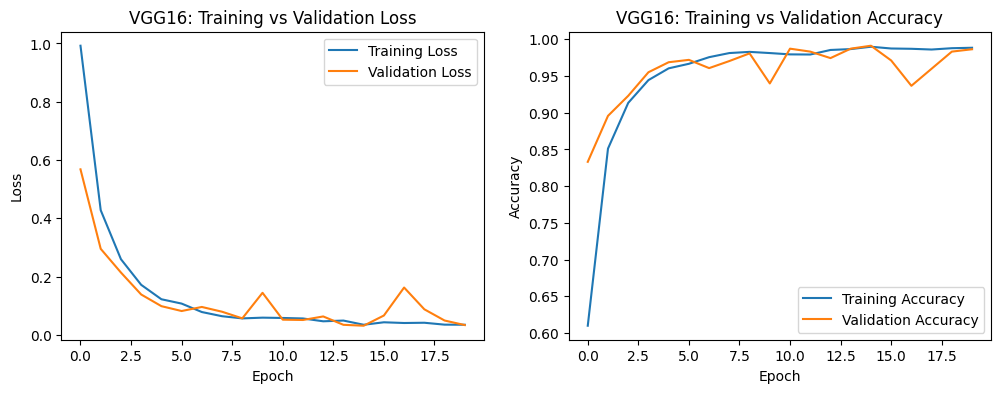

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title('VGG16: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Model Evaluation, Predictions and Metrics**

In [ ]:
#classification report
test_generator_vgg.reset()
vgg_preds = vgg_model.predict(test_generator_vgg, verbose=1)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)
true_classes_vgg = test_generator_vgg.classes
class_labels_vgg = list(test_generator_vgg.class_indices.keys())

print("Classification Report - VGG Model:")
print(classification_report(true_classes_vgg, vgg_pred_classes, target_names=class_labels_vgg))


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
Classification Report - VGG Model:
              precision    recall  f1-score   support

      Banana       1.00      1.00      1.00         1
      Cherry       1.00      1.00      1.00         1
       Grape       0.00      0.00      0.00         1
       Mango       0.00      0.00      0.00         1
       Peach       1.00      1.00      1.00         1

    accuracy                           0.60         5
   macro avg       0.60      0.60      0.60         5
weighted avg       0.60      0.60      0.60         5



In [ ]:
vgg_predictions = vgg_model.predict(test_generator_vgg, verbose=1)
vgg_predicted_classes = np.argmax(vgg_predictions, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [ ]:
class_names = list(train_generator.class_indices.keys())
vgg_predicted_labels = [class_names[i] for i in vgg_predicted_classes]

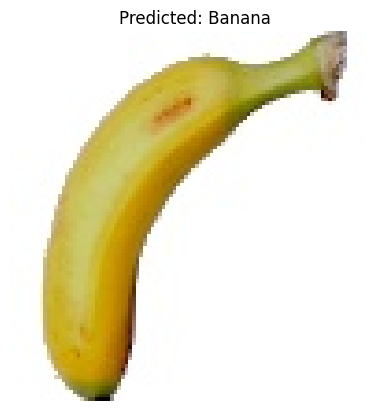

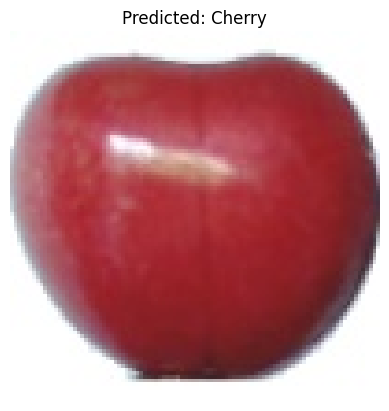

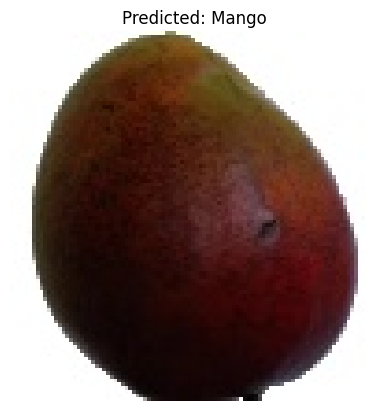

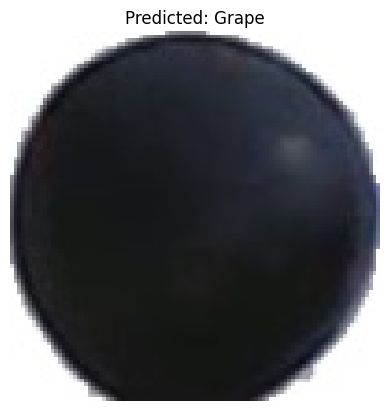

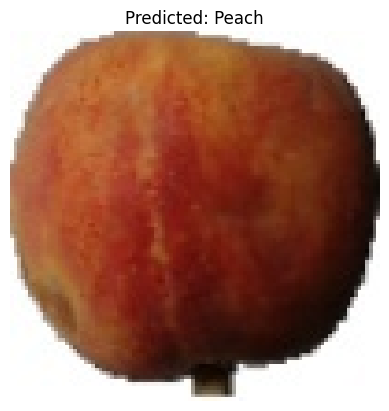

In [ ]:
# Set path to test data directory
test_data_dir = test_generator.directory

# Loop through filenames and predicted labels
for fn, label in zip(test_generator.filenames, vgg_predicted_labels):
    img_path = os.path.join(test_data_dir, fn)
    img = mpimg.imread(img_path)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {label}")
    plt.show()

Observation: The performance outcome of three different deep learning models on the fruit classification task. The models were evaluated based on the classification performance metrics such as precision, recall and f2-score and overall accuracy.

All three CNN Model got an accuracy of 60% and showed consistent classification performance, with three out of five classes accurately predicted. The main limitation was small validation sample sixe for model to apply which may have caused due to insufficient class diversity or imbalance, particularly for Grape and Mango class.

The baseline and pre-trained model both show gradual improvements in training and validation accuracy during early epochs suggesting effective learning input.

VGG16 model, however converges more steadily compared to baseline due to additional layers and normalization.

The pretrained model convegers rapidly within the first few epochs and then start to show divergence in training vs validation loss which is a clear sign of overfitting.

The classification report of all three models shows a high performance on Banana, Cherry and Peach classes which shows that there is a class imbalance of these classes in the dataset.
